## Preparation for galaxy light curve 
#### NGC 474 elliptical galaxy B

In [1]:
from astropy.io import fits
import os
import numpy as np
from astropy.modeling import models
from astropy.visualization import ZScaleInterval
from glob import glob
from astropy.table import Table
import matplotlib.pyplot as plt
import scipy.stats as stats
from astropy.stats import sigma_clipped_stats
from astropy.visualization import simple_norm
import photutils
from photutils.aperture import CircularAperture, ApertureStats
from photutils.aperture import aperture_photometry
from photutils.background import Background2D
from photutils.background import MedianBackground
from astropy.stats import sigma_clip
from astropy.wcs import WCS

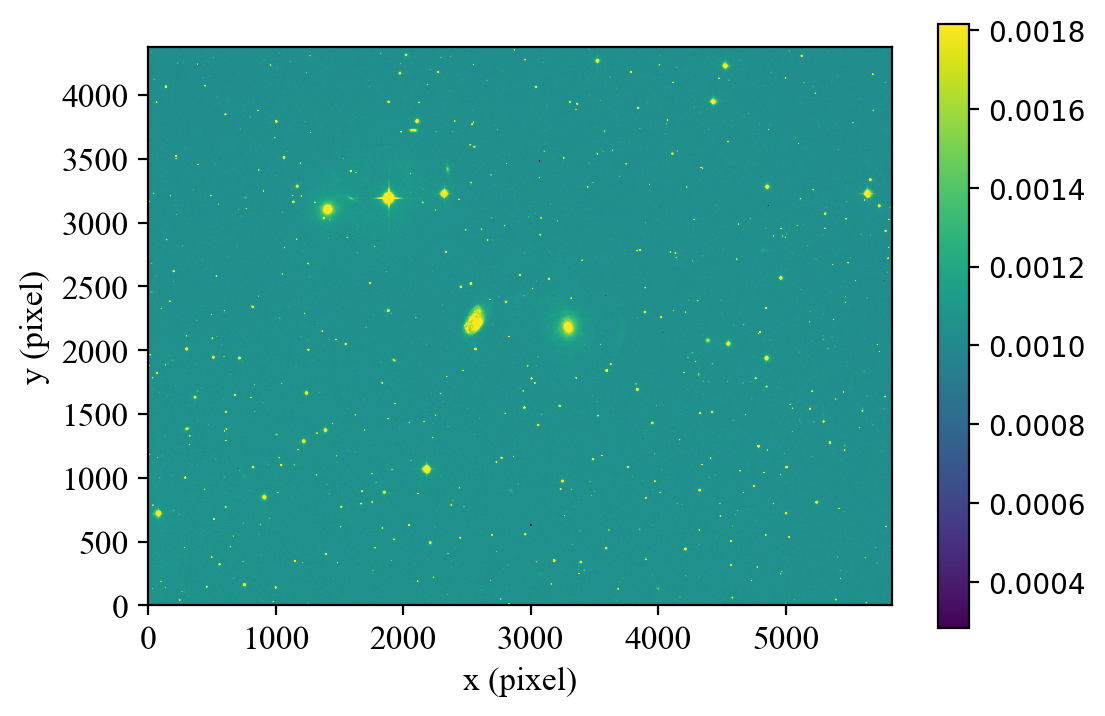

In [2]:
hdu = fits.open('Science/B/processed/stacked/NGC470_474_b_wcs.fits')
#hdu = fits.open('Science/V/processed/stacked/NGC470_474_V_wcs.fits')
#hdu = fits.open('Science/B/20231116_NGC470_474_B_5min-001.fit')
header = hdu[0].header
header = hdu[0].header
wcs = WCS(header)

## after siril stacking
from astropy.visualization import simple_norm

b_filter_stacked = hdu[0].data

# plot the b filter sci image
vmin, vmax = ZScaleInterval().get_limits(b_filter_stacked)
plt.figure(dpi=200)
norm = simple_norm(b_filter_stacked, stretch='sqrt', percent=99.9)

#plt.imshow(v_filter_stacked,  origin='lower', norm=norm)
font = {  
    'size': 12,         
    'name': 'Times New Roman',
    'weight': 'normal', 
}

#plt.title('Single master image in B filter', fontfamily='Times New Roman', fontsize=15)
plt.xlabel(r'x (pixel)',fontdict = font)  
plt.ylabel(r'y (pixel)',fontdict = font) 

plt.xticks(fontname='Times New Roman', fontsize=12)   
plt.yticks(fontname='Times New Roman', fontsize=12)
# zoom in of NGC440
plt.imshow(b_filter_stacked, origin='lower', vmin=vmin, vmax=vmax,)
plt.colorbar()
#plt.title(r'B filter stacked', )

plt.show()



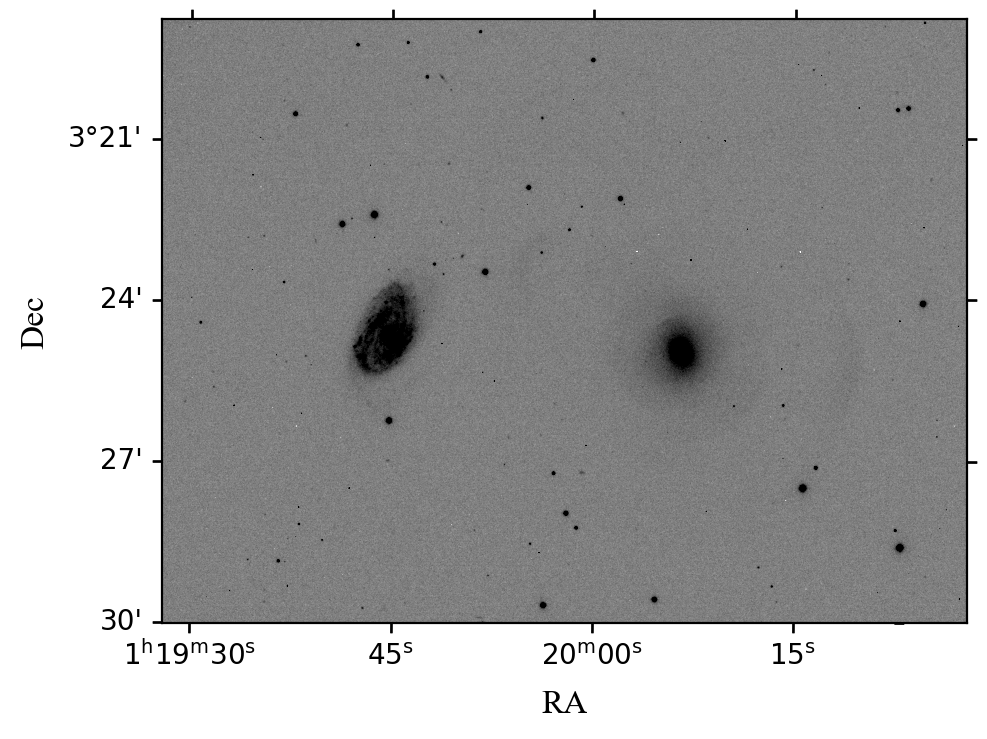

In [3]:
#fig = plt.figure(figsize=(8, 8))
fig = plt.figure(dpi = 200)
ax = plt.subplot(projection=wcs)

aa = ax.imshow(b_filter_stacked, origin='lower', vmin=vmin, vmax=vmax, cmap='gist_yarg')

font = {  
    'size': 12,         
    'name': 'Times New Roman',
    'weight': 'normal', 
}

#plt.title('Stacked image of NGC470 & NGC474 in B filter', fontfamily='Times New Roman', fontsize=15)
plt.xlabel(r'RA',fontdict = font)  
plt.ylabel(r'Dec',fontdict = font) 

#plt.colorbar(aa)
plt.xticks(fontname='Times New Roman', fontsize=12)   
plt.yticks(fontname='Times New Roman', fontsize=12)
plt.xlim(2000,4000)
plt.ylim(1500,3000)
plt.show()

In [4]:
##### calculations of background brightness #####
from astropy.stats import sigma_clipped_stats

results = sigma_clipped_stats(b_filter_stacked, sigma=5, maxiters=5) 
# here I set the sigma as 5 since there are faint objects.
results # mean, median, std

(0.0010519059, 0.0010488757, 0.00013502664)

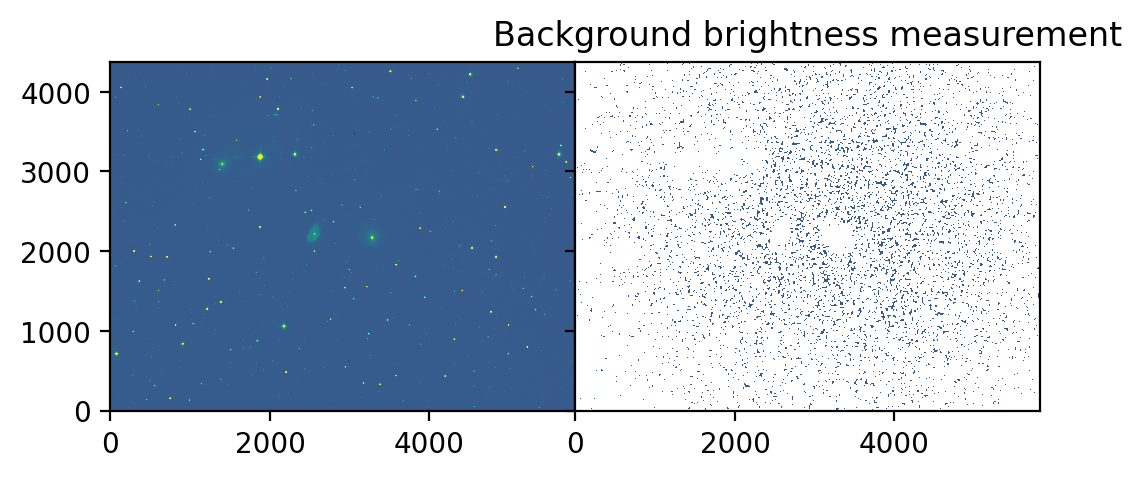

In [5]:
# check the image after sigma clipping
b_filter_clipped_img = sigma_clip(b_filter_stacked)
# background(mean, median, std)=(0.0010519059, 0.0010488757, 0.00013502664)

# plot the image after sigma clipping
fig, ax = plt.subplots(nrows=1, ncols=2, dpi=200, sharey=True)

ax[0].imshow(b_filter_stacked, origin='lower', norm=norm)
ax[1].imshow(b_filter_clipped_img, origin='lower', norm=norm)

plt.subplots_adjust(wspace=0)
plt.title('Background brightness measurement')
#ax[0].set_xticks([])
#ax[0].set_yticks([])
#ax[1].set_xticks([])
plt.show()

In [6]:
### bacjground brightness #####
#b_filter_bk_subtracted = sigma_clipped_stats(b_filter_stacked, sigma=5, maxiters=5) 

# Estimate the background using sigma-clipped statistics
mean, median, std = sigma_clipped_stats(b_filter_stacked, sigma=5, maxiters=5)
bkg_error = std
# Subtract the background contribution
b_filter_subtracted = b_filter_stacked - median  # something wrong here, but believe first
## b_filter_stacked-median*np.pi*i**2
b_filter_subtracted

array([[ 1.36345741e-04, -1.78732560e-04, -9.30566457e-05, ...,
         6.99433731e-05,  1.29981549e-04,  8.48365016e-06],
       [-1.16917770e-04, -1.43129146e-05, -1.34696485e-04, ...,
        -4.97361179e-06, -3.84228770e-06, -2.21014488e-05],
       [-8.28685588e-05, -1.20949699e-04, -5.45594376e-05, ...,
         1.71271968e-04,  6.87228749e-05, -2.26378266e-04],
       ...,
       [ 3.94780422e-04,  1.89024140e-04, -3.45098088e-05, ...,
         1.10984896e-04, -1.10543799e-04,  1.83091499e-04],
       [-5.50135737e-05, -7.99077097e-05, -2.20135378e-04, ...,
         1.79816270e-05,  2.84015667e-04, -9.41776671e-06],
       [-2.83319503e-04, -1.33460038e-04, -8.22460861e-05, ...,
        -2.31690006e-04, -8.67794733e-06, -1.95113244e-05]], dtype=float32)

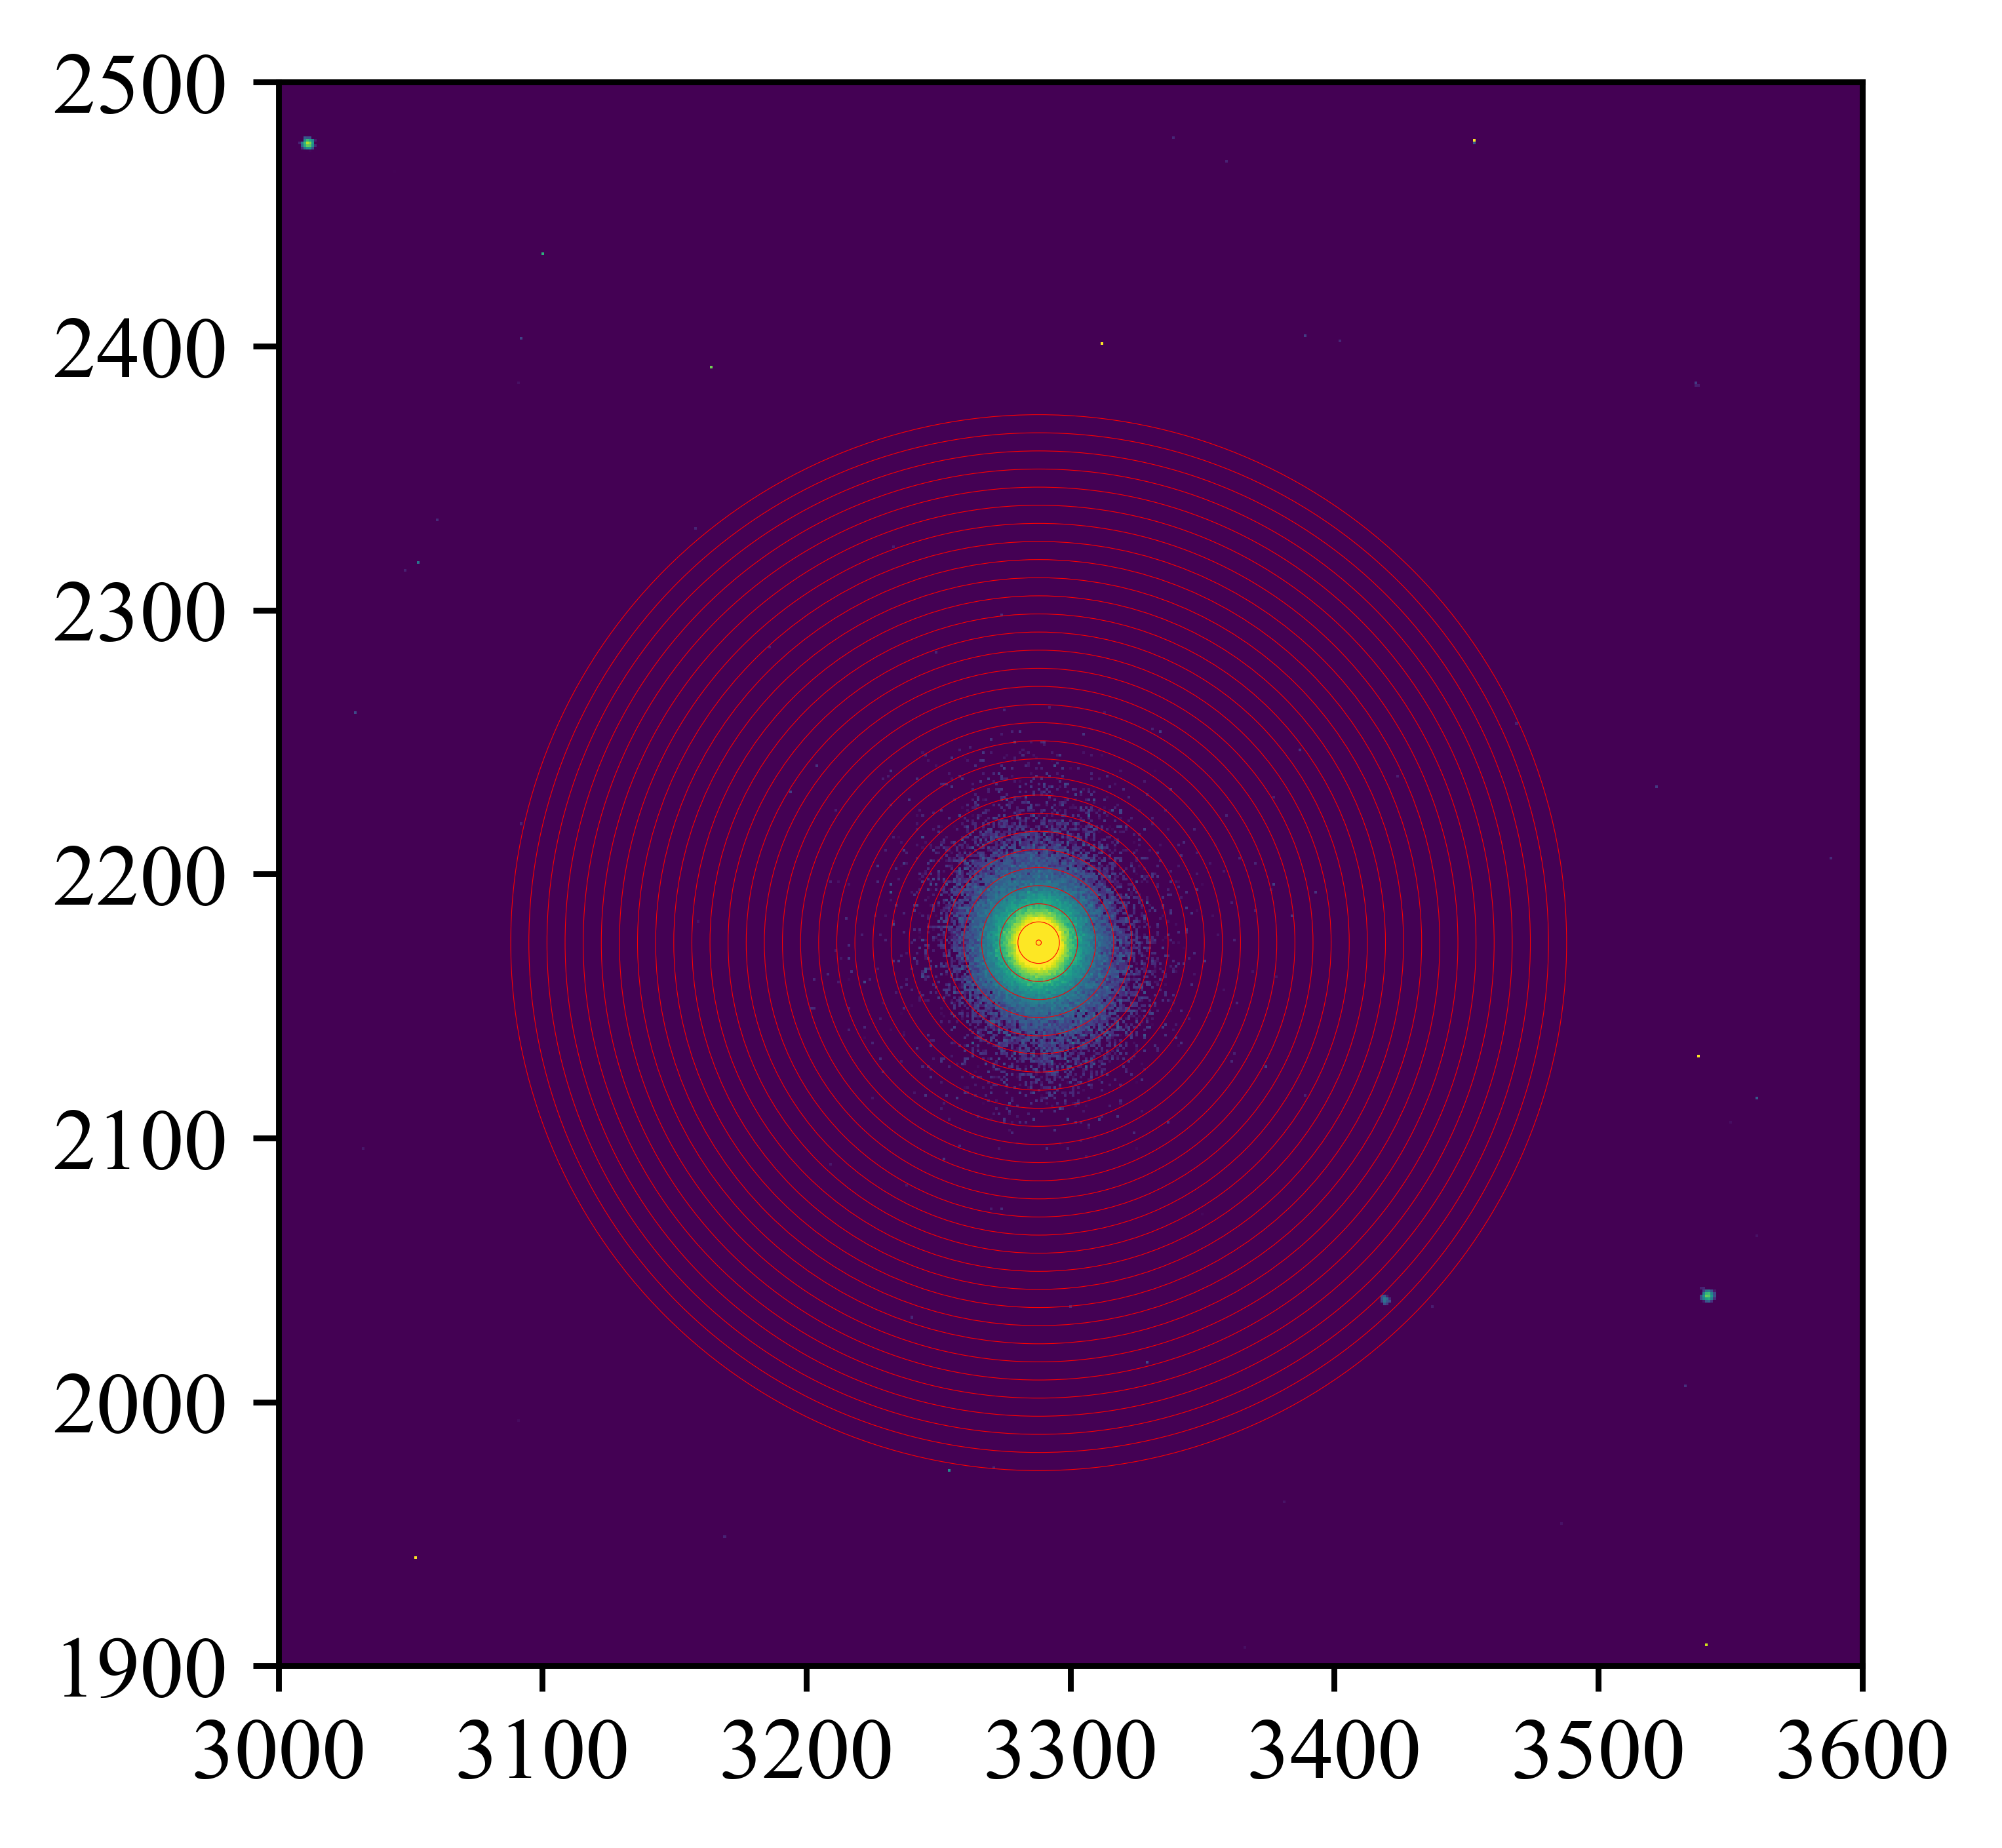

In [38]:
import photutils # use for photometry
from photutils.aperture import CircularAperture
from photutils.aperture import ApertureStats

plt.figure(dpi=800)
rad = np.linspace(1, 200,30)

flux = []
flux_error = []

for i in range(len(rad)): # 3288 2174 for b  # 3272 2156 for v
    aper = CircularAperture([3288, 2174], rad[i]) # give x,y postion and radius FOR u filter
    aper.plot(color='r', lw=0.1)
    i = i+15  # for marking center
    aperstats = ApertureStats(b_filter_subtracted,aper)
    # find flux in the corresponding aperture
    
    phot_table = aperture_photometry(b_filter_subtracted, aper)
    #print(i,phot_table)
    #print(i,phot_table['aperture_sum'] [0])
    eee = std* np.sqrt(np.pi*i**2)
    #print(aperstats.sum, aperstats.sum_aper_area)
    flux.append(aperstats.sum)
    flux_error.append(eee)


#aper = CircularAperture([3288, 2174],rad)  
#aper.plot(color='r', lw=0.1)

#plt.legend()
plt.xlim(3000,3600)
plt.ylim(1900,2500)
plt.xticks(fontname='Times New Roman', fontsize=12)
plt.yticks(fontname='Times New Roman', fontsize=12)
plt.imshow(b_filter_subtracted, origin='lower',norm=norm )

In [25]:
print(flux_error)

[0.0, 0.00023932848685069251, 0.00047865697370138503, 0.0007179854605520776, 0.0009573139474027701, 0.0011966424342534628, 0.0014359709211041551, 0.0016752994079548475, 0.0019146278948055401, 0.002153956381656233, 0.0023932848685069255, 0.0026326133553576177, 0.0028719418422083103, 0.003111270329059003, 0.003350598815909695, 0.003589927302760388, 0.0038292557896110802, 0.004068584276461773, 0.004307912763312466, 0.004547241250163158, 0.004786569737013851, 0.005025898223864543, 0.005265226710715235, 0.0055045551975659275, 0.005743883684416621, 0.005983212171267313, 0.006222540658118006, 0.006461869144968698, 0.00670119763181939, 0.006940526118670084, 0.007179854605520776, 0.007419183092371468, 0.0076585115792221605, 0.007897840066072854, 0.008137168552923546, 0.00837649703977424, 0.008615825526624932, 0.008855154013475624, 0.009094482500326316, 0.009333810987177008, 0.009573139474027702, 0.009812467960878393, 0.010051796447729086, 0.010291124934579777, 0.01053045342143047, 0.01076978190

#### plot curve of growth

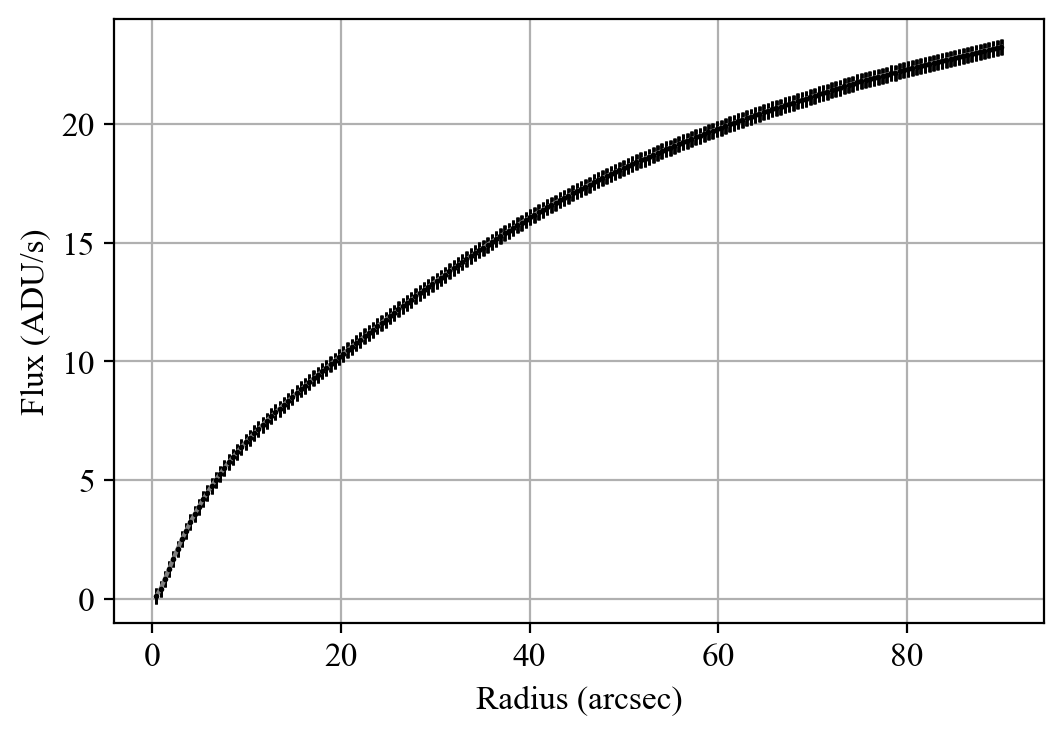

In [26]:
font = {  
    'size': 12,         
    'name': 'Times New Roman',
    'weight': 'normal', 
}

plt.figure(dpi=200)

plt.errorbar(0.45*rad, flux, xerr=flux_error, fmt='o', color='black', markersize=1, capsize=3)
plt.plot(0.45*rad, flux ,c='grey') # /np.max(flux) for normalization  # 7.52um,0.45" for one pixel after binning

#plt.title('Curve of growth of NGC474 B filter', fontfamily='Times New Roman', fontsize=15)
plt.xlabel(r'Radius (arcsec)',fontdict = font)  
plt.ylabel(r'Flux (ADU/s)',fontdict = font) 
#plt.xlim(0,40)
#plt.ylim(0,31)
plt.xticks(fontname='Times New Roman', fontsize=12)   
plt.yticks(fontname='Times New Roman', fontsize=12)
plt.grid(True)
plt.show()

#### radial flux profile

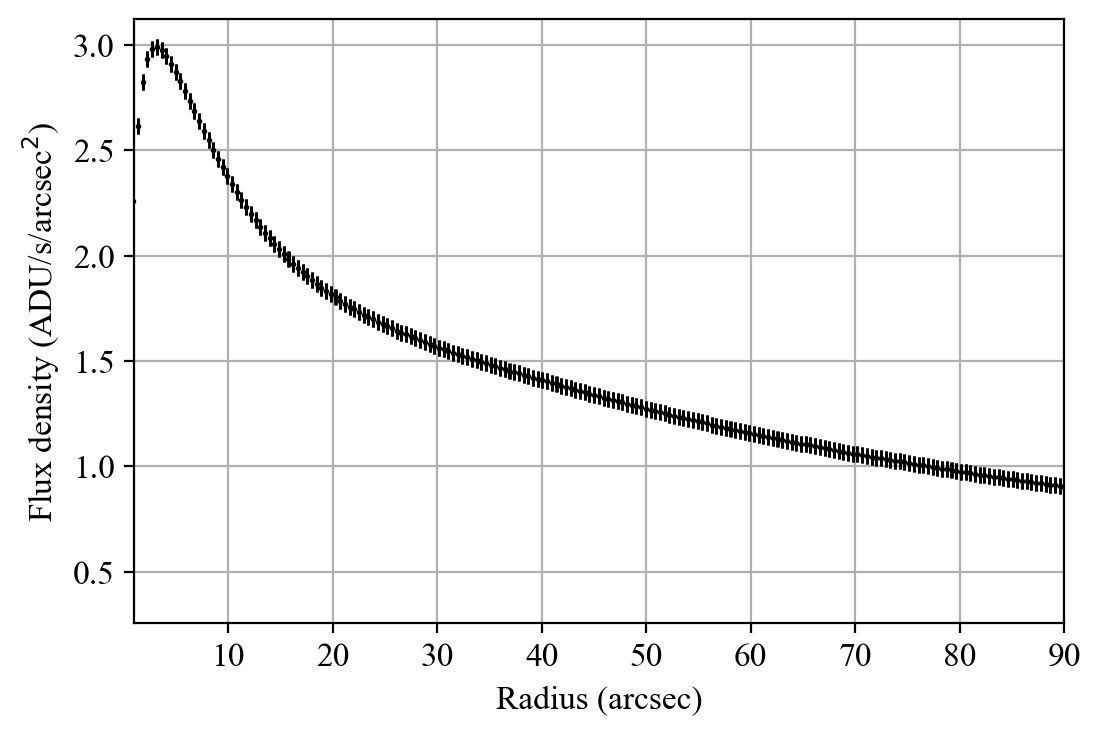

In [27]:
#rad
r_sq = (0.45*rad)**2
d_diff = np.diff(r_sq)
n = np.append(1, d_diff)
flux_density = flux/n*np.pi
flux_density_error = flux_error/n*np.pi
# plot radial flux density profile
font = {  
    'size': 12,         
    'name': 'Times New Roman',
    'weight': 'normal', 
}


plt.figure(dpi=200)
#plt.scatter(rad*0.45,flux_density, s= 2)
plt.errorbar(0.45*rad, flux_density, xerr=flux_density_error, fmt='o', color='black', markersize=1, capsize=3)
#plt.plot(rad*0.45,flux_density,c='grey') # /np.max(flux) for normalization  # 7.52um,0.45" for one pixel after binning

#plt.title('Radial Flux Profile of NGC474 B filter', fontfamily='Times New Roman', fontsize=15)
plt.xlabel(r'Radius (arcsec)',fontdict = font)  
plt.ylabel(r'Flux density (ADU/s/arcsec$^2$)',fontdict = font) 
plt.xlim(1,90)
plt.grid(True)
plt.xticks(fontname='Times New Roman', fontsize=12)   
plt.yticks(fontname='Times New Roman', fontsize=12)
plt.show()

#### curve fitting using sersic profile

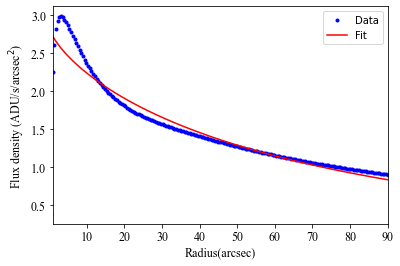

Fitted Amplitude: 2.839296648717098
Fitted Effective Radius (r_eff): 152.65940997371285
Fitted Sérsic Index (n): 1.3372668689281246


In [28]:
from scipy.optimize import curve_fit
from astropy.modeling import models

# Generate example data (replace this with your actual galaxy light profile data)
radius = np.linspace(1, 200,200)
#intensity = models.Sersic1D(amplitude=1, r_eff=5, n=2.5)(radius) + 0.1 * np.random.normal(size=len(radius))
intensity = flux_density
# Define the Sérsic profile function
def sersic_profile(r, amplitude, r_eff, n):
    return amplitude * np.exp(-((r / r_eff)**(1 / n)))

# Perform the curve fit
initial_guess = [9, 75.55, 2]  # Initial guess for amplitude, r_eff, and n
popt, pcov = curve_fit(sersic_profile, radius, intensity, p0=initial_guess)

# Extract the fitted parameters
amplitude_fit, r_eff_fit, n_fit = popt

# Generate the fitted Sérsic profile
fit_result = sersic_profile(radius, amplitude_fit, r_eff_fit, n_fit)

# Plot the original data and the fitted Sérsic profile
plt.plot(0.45*radius, intensity, 'b.', label='Data')
plt.plot(0.45*radius, fit_result, 'r-', label='Fit')
plt.xlabel('Radius(arcsec)',fontdict = font)
plt.ylabel('Flux density (ADU/s/arcsec$^2$)',fontdict = font)
plt.xticks(fontname='Times New Roman', fontsize=12)
plt.yticks(fontname='Times New Roman', fontsize=12)
#plt.title('Sérsic Profile Fitting')
plt.legend()
plt.xlim(1,90)
plt.show()

# Display the fitted parameters
print(f"Fitted Amplitude: {amplitude_fit}")
print(f"Fitted Effective Radius (r_eff): {r_eff_fit}")
print(f"Fitted Sérsic Index (n): {n_fit}")


#### surface brightness profile

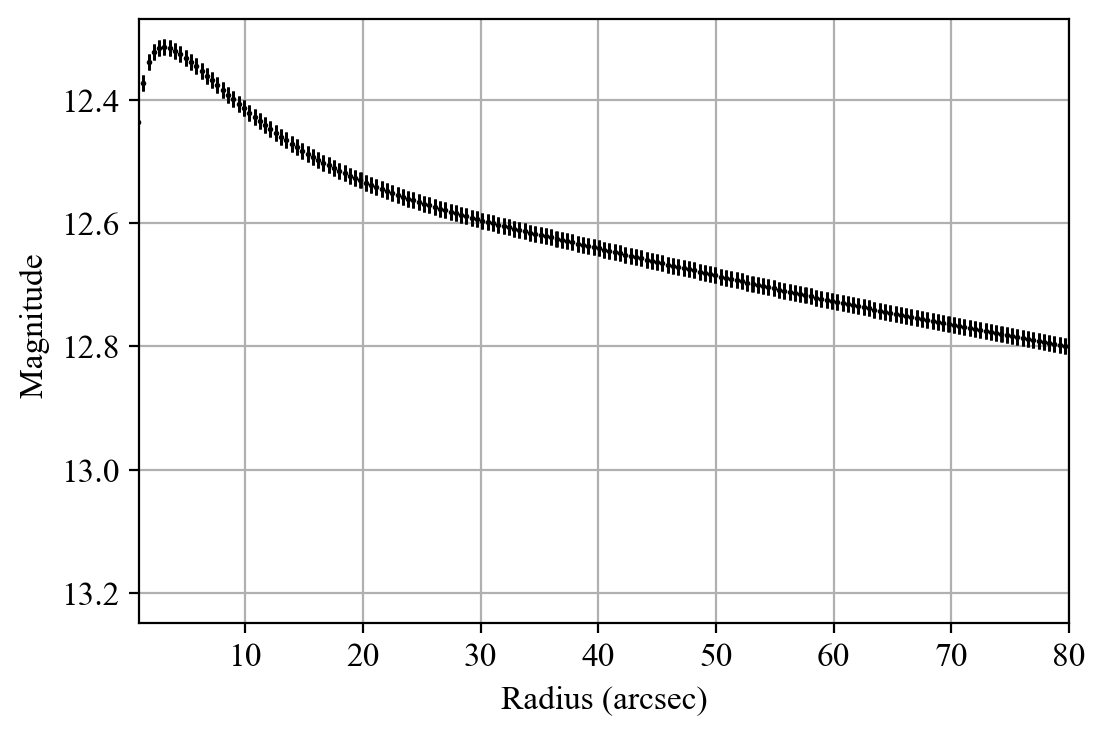

In [34]:
## convert flux density into magnitude
# 12.79 for b filter, 
mag = 12.79- np.log10(flux_density) # need revised  # magnitude in per pixel**2
# check APASS standard star catalog
# and the uncertainties
mag_error = -2.5*flux_density_error/flux_density/np.log(10)
# plot the surface brightness profile
plt.figure(dpi=200)
#plt.scatter(rad*0.45,mag, s= 2,c = 'black')
plt.errorbar(0.45*rad, mag, xerr=mag_error, fmt='o', color='black', markersize=1, capsize=3)
#plt.plot(rad*0.45,mag, c='grey') # 0.059
plt.gca().invert_yaxis()
#plt.title('Magnitude Profile of NGC474 B filter', fontfamily='Times New Roman', fontsize=15)

plt.xlim(1,80)
plt.grid(True)
plt.xlabel(r'Radius (arcsec)',fontdict = font)  
plt.ylabel(r'Magnitude ',fontdict = font) 
plt.xticks(fontname='Times New Roman', fontsize=12)   
plt.yticks(fontname='Times New Roman', fontsize=12)
plt.show()
